# ДОМАШНЕЕ ЗАДАНИЕ 2. Выбор модели

## Вариант 

In [1]:
surname = "Минайчев"  # Ваша фамилия

alph = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
w = [4, 42, 21, 21, 34,  1, 44, 26, 18, 43, 38, 26, 18, 43,  3, 49, 45,
        7, 42, 25,  4,  9, 36, 33, 31, 29,  5, 31,  4, 19, 24, 27, 33]
d = dict(zip(alph, w))
variant =  sum([d[el] for el in surname.lower()]) % 2 + 1
print("Ваш вариант - ", variant)

Ваш вариант -  1


## Задание 1. Реализация собственных классов и функций

Импортируем необходимые библиотеки

In [2]:
import numpy as np
import pandas as pd
import random
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.base import is_regressor 
from numpy import polyval, poly1d, flip


1. Реализуйте класс, предназначенный для оценки параметров линейной регрессии с регуляризацией совместимый с sklearn. Передаваемые параметры: 1) коэффициент регуляризации (alpha). Использовать метод наименьших квадратов с регуляризацией.

In [3]:
class CustomRidge(BaseEstimator, RegressorMixin):
    
    def __init__(self, alpha = 0, add_unit_vector = True):
        self.alpha = alpha
        self.add_unit_vector = add_unit_vector #добавлять ли единичный вектор к входным данным
    
    def fit(self, X, y):
        X_ = X.copy()
        if self.add_unit_vector:
            X_ = np.c_[np.ones(X.shape[0]), X]
        A = np.eye(X_.shape[1])
        A[0,0] = 0
        fine = np.dot(A, self.alpha)
        self.coef_ = np.linalg.inv(X_.T @ X_ + fine) @ X_.T @ y
        return self
    
    def predict(self, X):
        X_ = np.c_[X]
        if self.add_unit_vector:
            X_ = np.c_[np.ones(X.shape[0]), X]
        return X_ @ self.coef_

2. Реализуйте класс для стандартизации признаков в виде трансформации совместимый с sklearn. Передаваемые параметры: 1) has_bias (содержит ли матрица вектор единиц), 2) apply_mean (производить ли центровку)

In [4]:
class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, y, has_bias = False, apply_mean = False):
        self.has_bias = has_bias
        self.apply_mean = apply_mean
        self.y = y
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        y = self.y
        sx_mean = X_.mean()
        sx_std = X_.std()
        sy_mean = self.y.mean()
        if self.has_bias == True:
            X_ = X_[:,1:]
        if self.apply_mean == True:
            for i in range(0, len(X_)):
                X_[i] = X_[i] - sx_mean
                self.y[i] = self.y[i] - sy_mean
        for i in range(0, len(X_)):
            X_[i] = (X_[i] - sx_mean) / sx_std
        return X_

3.Использую класс Pipeline, выполнить обучение линейной регрессии для всего набора данных с коэффициентом регуляризации равным 0.01. Выведите значения параметров обученной модели. Отобразите исходные данные и график функции предсказания.

In [5]:
FILE_PATH = "..\Assignments-master\data\A2_Model_Selection\Reg_A5.csv" # путь к данным

In [6]:
df = pd.read_csv(FILE_PATH, sep=",")
df.head(5)

,X,Y
0,3.856603,9.209759
1,0.103760,10.409240
2,3.168241,7.643742
3,3.744019,8.453341
4,2.492535,9.317824


In [7]:
X = df["X"].values
y = df["Y"].values

In [8]:
pipeline = Pipeline([
    ("standartization", CustomFeatureTransformer(y)), #кастомная стандартизация
    ("ridge", CustomRidge(0.01)) #кастомная модель
])
pipeline.fit(X, y)
print(f'R^2 = {pipeline.score(X, y)}')
pipeline.named_steps['ridge'].coef_

R^2 = 0.22583064709760348


array([ 9.44892102, -0.40381569])

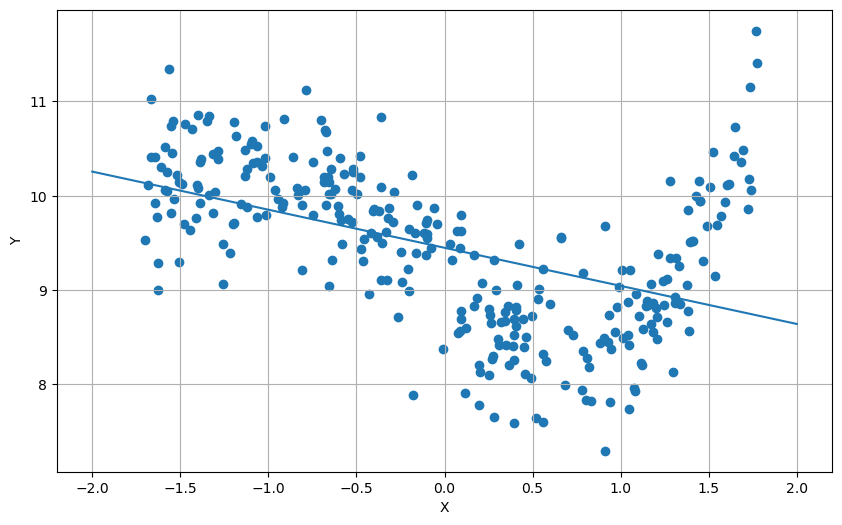

In [9]:
sx_std = X.std()
sx_mean = X.mean()
for i in range(0, len(X)): #стандартизация исходных данных для корректного отображени на графике
    X[i] = (X[i] - sx_mean) / sx_std
plt.figure("1", figsize=[10, 6])
plt.subplot(1,1,1)

plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
x_line = np.array([-2, 2])
h_pred_1 = lambda x: pipeline.named_steps['ridge'].coef_[1] * x + pipeline.named_steps['ridge'].coef_[0] # 9.44892102 -0.40381569
plt.plot(x_line, h_pred_1(x_line), "-")

plt.show()

4. Реализуйте функции для расчета MSE и R^2 при отложенной выборке (run_holdout) и кросс-валидации (run_cross_val). Для кросс-валидации используйте только класс KFold. Выходными значениями должны быть MSE и R^2 для обучающей и тестовой частей.

In [10]:
def run_holdout(model, X, y, train_size, random_state = 0) -> dict:
    shuffle_X = shuffle(X, random_state = random_state) #шафл для перемешивания данных
    shuffle_y = shuffle(y, random_state = random_state)
    train_size = int(train_size * len(X)) 
    X_train = shuffle_X[:train_size]
    X_test = shuffle_X[train_size:]
    y_train = shuffle_y[:train_size]
    y_test = shuffle_y[train_size:]
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train) 
    y_pred_test = model.predict(X_test)
    MSE_train = np.square(np.subtract(y_train,y_pred_train)).mean()
    MSE_test = np.square(np.subtract(y_test,y_pred_test)).mean()
    corr_matrix_train = np.corrcoef(y_train, y_pred_train)
    corr_train = corr_matrix_train[0,1]
    R_sq_train = corr_train**2
    corr_matrix_test = np.corrcoef(y_test, y_pred_test)
    corr_test = corr_matrix_test[0,1]
    R_sq_test = corr_test**2
    scores = {"MSE_train" : MSE_train, "MSE_test" : MSE_test, "R^2_train" : R_sq_train, "R^2_test" : R_sq_test}
    return scores

In [11]:
def run_cross_val(model, X, y, n_splits, shuffle, random_state = 0) -> dict:
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    MSE_train = 0
    MSE_test = 0
    R_sq_train = 0
    R_sq_test = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        MSE_train += np.square(np.subtract(y_train,y_pred_train)).mean()
        MSE_test += np.square(np.subtract(y_test,y_pred_test)).mean()
        corr_matrix_train = np.corrcoef(y_train, y_pred_train)
        corr_train = corr_matrix_train[0,1]
        R_sq_train += corr_train**2
        corr_matrix_test = np.corrcoef(y_test, y_pred_test)
        corr_test = corr_matrix_test[0,1]
        R_sq_test += corr_test**2
    MSE_train = MSE_train / n_splits
    MSE_test = MSE_test / n_splits
    R_sq_train = R_sq_train / n_splits
    R_sq_test = R_sq_test / n_splits
    scores = {"MSE_train" : MSE_train, "MSE_test" : MSE_test, "R^2_train" : R_sq_train, "R^2_test" : R_sq_test}
    return scores

5.Выведите значения MSE и R^2, полученные посредством функций run_holdout и run_cross_val. Использовать следующие параметры:

- `train_size=0.75`, 
- `n_splits=4`, 
- `shuffle=True`, 
- `random_state=0`

In [12]:
run_holdout(pipeline,X, y, 0.75)

{'MSE_train': 0.566727650245596,
 'MSE_test': 0.5278886478193137,
 'R^2_train': 0.21386160352810235,
 'R^2_test': 0.27903331441056217}

In [13]:
run_cross_val(pipeline, X, y, 4, True)

{'MSE_train': 0.5579909036370301,
 'MSE_test': 0.561093237262455,
 'R^2_train': 0.22757647386537488,
 'R^2_test': 0.24164106470403435}

## Задание 2

Дано множество наблюдений (см. набор данных к заданию), модель - линейная регрессия (без регуляризации, с нормализацией). Найти степень полинома с минимальной ошибкой на проверочном подмножестве, определить среднеквадратическую ошибку на тестовом подмножестве (степень полинома от 1 до 25). Сделать заключение о влиянии степени полинома регуляризации.

In [14]:
df1 = pd.read_csv(FILE_PATH, sep=",") #читаем данные в df
df1.head(5)

,X,Y
0,3.856603,9.209759
1,0.103760,10.409240
2,3.168241,7.643742
3,3.744019,8.453341
4,2.492535,9.317824


1. Отображение исходных данных на графике

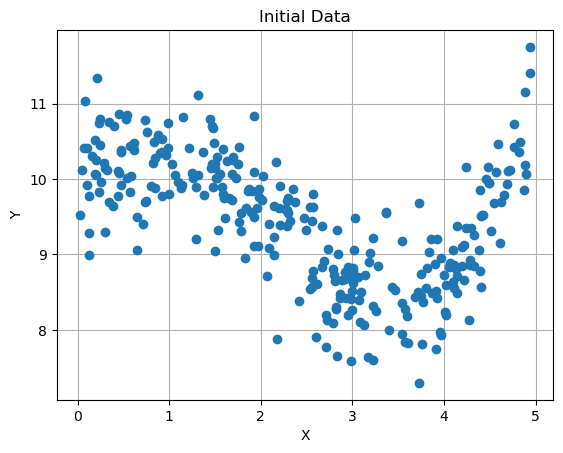

In [15]:
X = df1["X"].values
y = df1["Y"].values
plt.title("Initial Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(X, y, "o")
plt.grid(True)
plt.show()


Согласно методике выбора моделей, делим исходные данные на train и test часть, чтобы в дальнейшем поделить train часть на {train, validate} части.

In [16]:
train_size = int(0.7 * len(X))
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

Используя функции из задания 1, проведем подбор модели от степени полинома для обучающего(train) и проверочного(validation) подмножеств по среднеквадратической ошибке и коэффициенту детерминации.

In [17]:
X_train = X_train.reshape(-1, 1)
X = X.reshape(-1, 1)
mse_train_holdout = []
mse_validation_holdout = []
R_sq_train_holdout = []
R_sq_validation_holdout = []
for i in range (1,26):
    pipeline_poly = Pipeline([("standartization", CustomFeatureTransformer(y)),
                         ("pf", PolynomialFeatures(degree=i)),
                         ("ridge", CustomRidge(0, False))])
    results = run_holdout(pipeline_poly,X_train, y_train, 0.75)
    mse_train_holdout.append(results["MSE_train"]) 
    mse_validation_holdout.append(results["MSE_test"]) #параметры с _test в данном случае принадлежат к validate подмножеству
    R_sq_train_holdout.append(results["R^2_train"])
    R_sq_validation_holdout.append(results["R^2_test"])
print(mse_validation_holdout)


[0.4280391130307022, 0.3929939848352551, 0.4523742450568306, 0.5101075398334145, 0.5027345187570494, 0.5265846449332882, 0.7034601025205925, 0.5947670653617471, 0.515062399508483, 0.48690519979140884, 1.089206022893897, 1.6832160400440503, 4.651394662169166, 2.05617030117841, 42.99265165686417, 259.8825269856291, 296.9135038482191, 1.26299602443703, 267.2553836729505, 1562.3181652085586, 2402.993473590217, 1278.6015209177906, 123589.81855301769, 117836.49775405916, 347625.7040948703]


In [18]:
mse_train_KFold = []
mse_validation_KFold = []
R_sq_train_KFold = []
R_sq_validation_KFold = []
for i in range (1,26):
    pipeline_poly = Pipeline([("standartization", CustomFeatureTransformer(y)),
                         ("pf", PolynomialFeatures(degree=i)),
                         ("ridge", CustomRidge(0, False))])
    results = run_cross_val(pipeline_poly, X_train, y_train, 4, True)
    mse_train_KFold.append(results["MSE_train"])
    mse_validation_KFold.append(results["MSE_test"])
    R_sq_train_KFold.append(results["R^2_train"])
    R_sq_validation_KFold.append(results["R^2_test"])
    


Построю график зависимости коэффициента детерминации (R^2) от степени полинома для обучающего и проверочного подмножеств, подсчитанных ячейками выше.

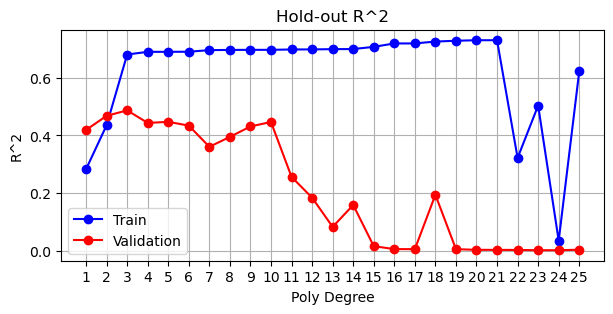

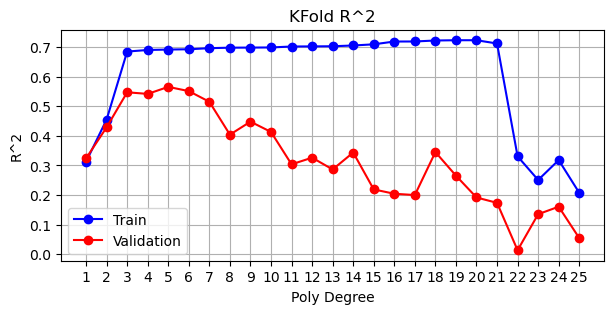

In [19]:
plt.figure(figsize=[7, 3])
plt.title("Hold-out R^2")
plt.xlabel("Poly Degree")
plt.ylabel("R^2")
plt.plot(R_sq_train_holdout, "b-o", label='Train')
plt.plot(R_sq_validation_holdout, "r-o", label='Validation')
plt.legend()
plt.xticks(np.arange(len(R_sq_train_holdout)), np.arange(1, len(R_sq_train_holdout)+1))
plt.grid(True)

plt.figure(figsize=[7, 3])
plt.title("KFold R^2")
plt.xlabel("Poly Degree")
plt.ylabel("R^2")
plt.plot(R_sq_train_KFold, "b-o", label='Train')
plt.plot(R_sq_validation_KFold, "r-o", label='Validation')
plt.legend()
plt.xticks(np.arange(len(R_sq_train_KFold)), np.arange(1, len(R_sq_train_KFold)+1))
plt.grid(True)

Построю график зависимости среднеквадратической ошибки (MSE) от степени полинома для обучающего и проверочного подмножеств, подсчитанных ячейками выше.

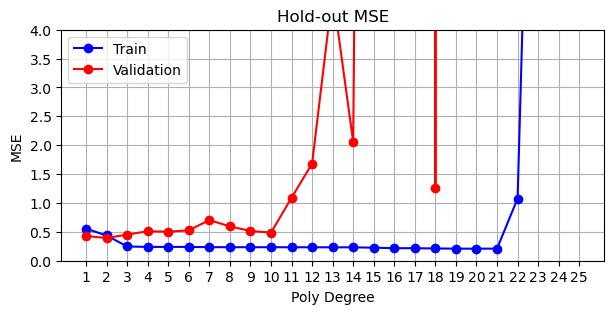

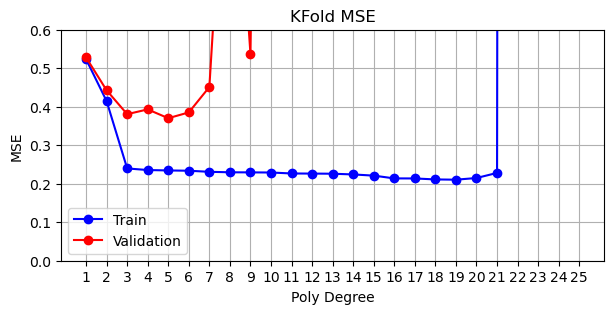

In [20]:
plt.figure(figsize=[7, 3])
plt.title("Hold-out MSE")
plt.xlabel("Poly Degree")
plt.ylabel("MSE")
plt.plot(mse_train_holdout, "b-o", label='Train')
plt.plot(mse_validation_holdout, "r-o", label='Validation')
plt.legend()
plt.ylim(0, 4)
plt.xticks(np.arange(len(mse_validation_holdout)), np.arange(1, len(mse_validation_holdout)+1))
plt.grid(True)

plt.figure(figsize=[7, 3])
plt.title("KFold MSE")
plt.xlabel("Poly Degree")
plt.ylabel("MSE")
plt.plot(mse_train_KFold, "b-o", label='Train')
plt.plot(mse_validation_KFold, "r-o", label='Validation')
plt.legend()
plt.xticks(np.arange(len(mse_train_KFold)), np.arange(1, len(mse_train_KFold)+1))
plt.ylim(0, 0.6)
plt.grid(True)

Как видно из графиков - среднеквадратичная ошибка с полиномом первой степени довольно большая, она уменьшается с ростом степени до определенного - минимального значения, после которого начинает расти стремительными темпами.

In [21]:
print("Степень полинома с наименьшей среднеквадратичной ошибкой (MSE) для holdout способа -",np.argmin(mse_validation_holdout)+1)
print("Степень полинома с наименьшей среднеквадратичной ошибкой (MSE) для кросс-валидации KFold -",np.argmin(mse_validation_KFold)+1)
print("Степень полинома с наибольшим коэффициентом детерминации (R^2) для holdout способа -",np.argmax(R_sq_validation_holdout)+1)
print("Степень полинома с наибольшим коэффициентом детерминации (R^2) для кросс-валидации KFold -",np.argmax(R_sq_validation_KFold)+1)


Степень полинома с наименьшей среднеквадратичной ошибкой (MSE) для holdout способа - 2
Степень полинома с наименьшей среднеквадратичной ошибкой (MSE) для кросс-валидации KFold - 5
Степень полинома с наибольшим коэффициентом детерминации (R^2) для holdout способа - 3
Степень полинома с наибольшим коэффициентом детерминации (R^2) для кросс-валидации KFold - 5


Степень для MSE Holdout способа отличается от степени для R^2, это связано недостаточностью данных для валидации.

Выведу функцию регрессии для наилучшей модели среди среди выбранных для двух способов - holdout и кросс-валидации, а также построю график с исходными данными и данной функцией.

In [22]:
X = df1["X"].values
y = df1["Y"].values
X = X.reshape(-1, 1)
pipeline_poly_KFold = Pipeline([("standartization", CustomFeatureTransformer(y)),
                         ("pf", PolynomialFeatures(degree=np.argmax(R_sq_validation_KFold)+1)),
                         ("ridge", CustomRidge(0, False))])
results_KFold = run_cross_val(pipeline_poly_KFold, X, y, 4, True)
interception = pipeline_poly_KFold.named_steps["ridge"].coef_[0]
pipeline_poly_KFold.named_steps["ridge"].coef_[0] = 0 
f_pred_kfold = lambda x : polyval(pipeline_poly_KFold.named_steps["ridge"].coef_, x) + interception # функция регрессии
pipeline_poly_KFold.named_steps["ridge"].coef_ = np.flip(pipeline_poly_KFold.named_steps["ridge"].coef_, 0)
print(poly1d(pipeline_poly_KFold.named_steps["ridge"].coef_), '+', interception) # вывод функции полинома

          5           4          3          2
-0.05676 x + 0.07719 x + 0.7974 x + 0.2461 x - 1.582 x + 9.112738316923929


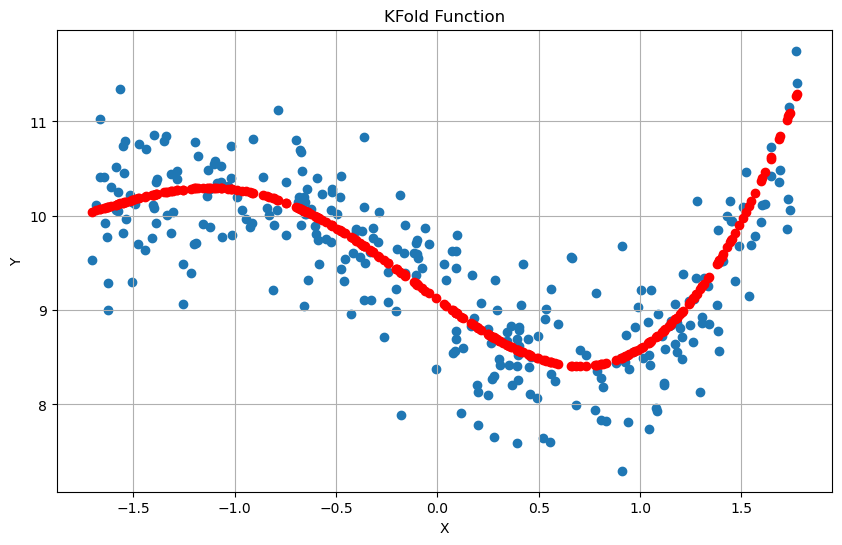

In [23]:
sx_std = X.std()
sx_mean = X.mean()
for i in range(0, len(X)):
    X[i] = (X[i] - sx_mean) / sx_std
plt.figure("1", figsize=[10, 6])
plt.subplot(1,1,1)

plt.scatter(X, y)
plt.title("KFold Function")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
x_line = np.array([-2, 2])
plt.plot(X, f_pred_kfold(X), "o", color="red", lw=2)

In [24]:
X = df1["X"].values
y = df1["Y"].values
X = X.reshape(-1, 1)
pipeline_poly_holdout_r2 = Pipeline([("standartization", CustomFeatureTransformer(y)),
                         ("pf", PolynomialFeatures(degree=np.argmax(R_sq_validation_holdout)+1)),
                         ("ridge", CustomRidge(0, False))])
results_holdout = run_holdout(pipeline_poly_holdout_r2,X, y, 0.70)
interception = pipeline_poly_holdout_r2.named_steps["ridge"].coef_[0]
pipeline_poly_holdout_r2.named_steps["ridge"].coef_[0] = 0 
f_pred_holdout_r2 = lambda x : polyval(pipeline_poly_holdout_r2.named_steps["ridge"].coef_, x) + interception
pipeline_poly_holdout_r2.named_steps["ridge"].coef_ = np.flip(pipeline_poly_holdout_r2.named_steps["ridge"].coef_, 0)
print(poly1d(pipeline_poly_holdout_r2.named_steps["ridge"].coef_), '+', interception)

        3          2
0.6238 x + 0.4117 x - 1.499 x + 9.098191660744885


In [25]:
X = df1["X"].values
y = df1["Y"].values
X = X.reshape(-1, 1)
pipeline_poly_holdout_mse = Pipeline([("standartization", CustomFeatureTransformer(y)),
                         ("pf", PolynomialFeatures(degree=np.argmin(mse_validation_holdout)+1)),
                         ("ridge", CustomRidge(0, False))])
results = run_holdout(pipeline_poly_holdout_mse,X, y, 0.70)
interception = pipeline_poly_holdout_mse.named_steps["ridge"].coef_[0]
pipeline_poly_holdout_mse.named_steps["ridge"].coef_[0] = 0 
f_pred_holdout_mse = lambda x : polyval(pipeline_poly_holdout_mse.named_steps["ridge"].coef_, x) + interception
pipeline_poly_holdout_mse.named_steps["ridge"].coef_ = np.flip(pipeline_poly_holdout_mse.named_steps["ridge"].coef_, 0)
print(poly1d(pipeline_poly_holdout_mse.named_steps["ridge"].coef_), '+', interception)

        2
0.3709 x - 0.38 x + 9.107576682932123


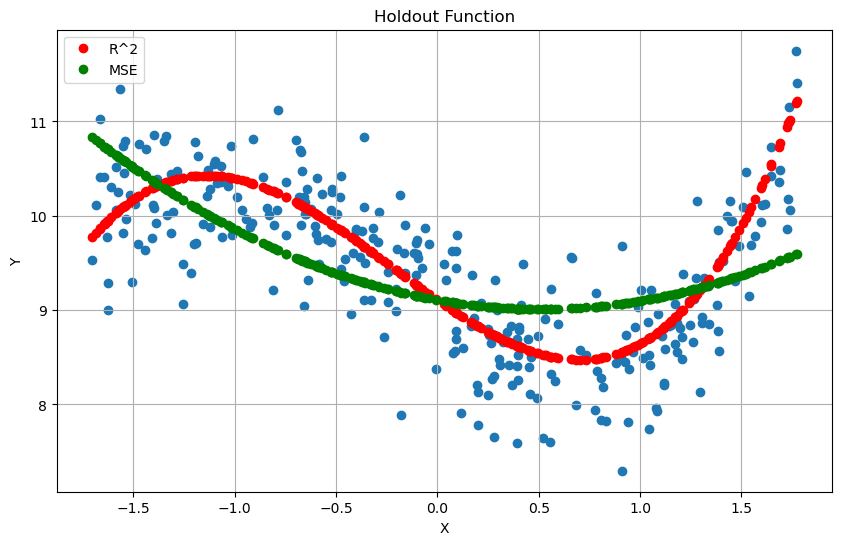

In [26]:
X = df1["X"].values
y = df1["Y"].values
X = X.reshape(-1, 1)
sx_std = X.std()
sx_mean = X.mean()
for i in range(0, len(X)):
    X[i] = (X[i] - sx_mean) / sx_std
plt.figure("1", figsize=[10, 6])
plt.subplot(1,1,1)

plt.scatter(X, y)
plt.title("Holdout Function")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
x_line = np.array([-2, 2])
plt.plot(X, f_pred_holdout_r2(X), "o", color="red", lw=2, label = 'R^2')
X = df1["X"].values
y = df1["Y"].values
X = X.reshape(-1, 1)
sx_std = X.std()
sx_mean = X.mean()
for i in range(0, len(X)):
    X[i] = (X[i] - sx_mean) / sx_std
plt.plot(X, f_pred_holdout_mse(X), "o", color="green", lw=2, label = 'MSE')
plt.legend()
plt.show() 

Выведем среднеквадратичную ошибку для HoldOut способа и кросс-валидации, обученные на всём объеме данных.

In [27]:
print("Holdout Среднеквадратичная ошибка - ", results_holdout['MSE_test'])
print("KFold Среднеквадратичная ошибка - ", results_KFold['MSE_test'])

Holdout Среднеквадратичная ошибка -  0.2871756854638636
KFold Среднеквадратичная ошибка -  0.305665106460031


Ошибка для KFold больше, однако это можно объяснить что holdout модель просто переобучена, для того чтобы удостовериться - нужно использовать больший набор исходных данных

## Задание 3

Дано множество наблюдений (см. набор данных к заданию), классификатор - логистическая регрессия. Найти степень полинома с минимальной ошибкой на проверочном подмножестве, определить долю правильных классификаций на тестовом подмножестве. Сделать заключение о влиянии степени полинома регуляризации.

Выведем исходные данные

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
FILE_PATH_TASK3 = "..\Assignments-master\data\A2_Model_Selection\Cl_A5_V1.csv"

In [29]:
df3 = pd.read_csv(FILE_PATH_TASK3, sep=",")
df3.head(5)

,X1,X2,Y
0,11.145485,4.790697,0
1,3.094885,4.787600,1
2,8.577163,3.914841,0
3,9.427682,5.266742,0
4,3.514624,6.213900,1


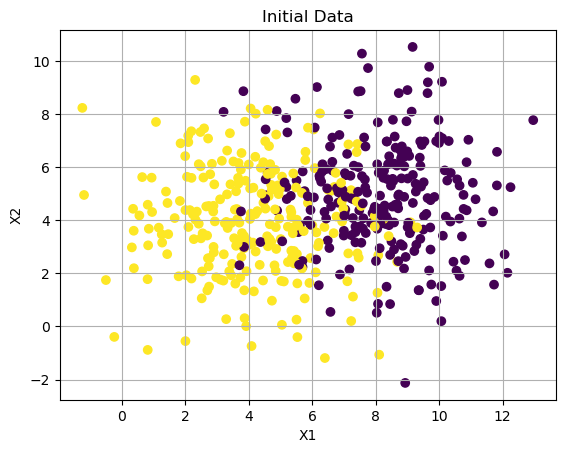

In [30]:
x1 = df3.X1.values
x2 = df3.X2.values
y = df3.Y.values

plt.title("Initial Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(df3.X1, df3.X2, c=df3.Y)
plt.grid(True)
plt.show()

In [31]:
x = np.column_stack((x1, x2)) #объединяем в одну переменную две независимые переменные X1 и X2

Делим исходные данные на тестовую, проверочную и обучающие подномножества при помощи функции train_test_split

In [32]:
x_train_main, x_test, y_train_main, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
x_train, x_validate, y_train, y_validate = train_test_split(x_train_main, y_train_main, test_size=0.25, random_state=0)


Будем использовать модель логистической регрессии из библиотеки sklearn, а также разобьем данные для кросс-валидации.

In [33]:
logr_model = LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1e5,
                                solver="liblinear", random_state=12345)
kf = KFold(n_splits=4, shuffle=True, random_state=0)

Построю график зависимости доли правильных классификаций от степени полинома для обучающего и проверочного подмножеств.

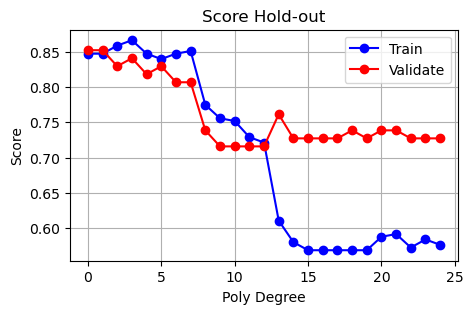

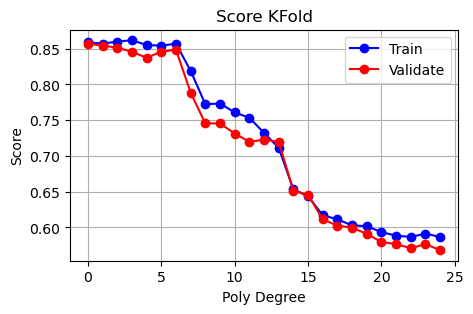

In [34]:
holdout_score_train = []
holdout_score_validate = []
kfold_score_train = []
kfold_score_validate = []

for i in range (1,26):
    pf = PolynomialFeatures(degree=i)
    
    x_train_poly = pf.fit_transform(x_train) #обучаем
    logr_model.fit(x_train_poly, y_train)
    holdout_score_train.append(logr_model.score(x_train_poly, y_train)) #добавлем оценку в соотв. массив
    
    x_validate_poly = pf.fit_transform(x_validate)
    holdout_score_validate.append(logr_model.score(x_validate_poly, y_validate))#добавлем оценку в соотв. массив
    
    pipeline_poly_KFold = Pipeline([("pf", PolynomialFeatures(degree=i)), #опишем пайплайн для функции cross-validate
                         ("logr", LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1e5,
                                solver="liblinear", random_state=12345))])
    cv_results = cross_validate(pipeline_poly_KFold, x_train_main, y_train_main, cv=kf, return_train_score=True)
    kfold_score_train.append(np.mean(cv_results['train_score'])) 
    kfold_score_validate.append(np.mean(cv_results['test_score']))

plt.figure(figsize=[5, 3])
plt.title("Score Hold-out")
plt.xlabel("Poly Degree")
plt.ylabel("Score")
plt.plot(holdout_score_train, "b-o", label = 'Train')
plt.plot(holdout_score_validate, "r-o", label = 'Validate')
plt.legend()
plt.grid(True)

plt.figure(figsize=[5, 3])
plt.title("Score KFold")
plt.xlabel("Poly Degree")
plt.ylabel("Score")
plt.plot(kfold_score_train, "b-o", label = 'Train')
plt.plot(kfold_score_validate, "r-o", label = 'Validate')
plt.legend()
plt.grid(True)

Как видно из графиков - оценка полинома первой степени довольно большая, она колеблится в значении степени до ~6, после чего начинает стремительно уменьшать

In [35]:
print ("Максимальная доля правильных классификаций на обучающей выборке соответствует степени полинома: ", 
       np.argmax(holdout_score_train)+1)
print ("Максимальная доля правильных классификаций на проверочной выборке соответствует степени полинома: ", 
       np.argmax(holdout_score_validate)+1)
print ("Максимальная доля правильных классификаций на обучающей выборке (KFold) соответствует степени полинома: ", 
       np.argmax(kfold_score_train)+1)
print ("Максимальная доля правильных классификаций на проверочной выборке (KFold) соответствует степени полинома: ", 
       np.argmax(kfold_score_validate)+1)

Максимальная доля правильных классификаций на обучающей выборке соответствует степени полинома:  4
Максимальная доля правильных классификаций на проверочной выборке соответствует степени полинома:  1
Максимальная доля правильных классификаций на обучающей выборке (KFold) соответствует степени полинома:  4
Максимальная доля правильных классификаций на проверочной выборке (KFold) соответствует степени полинома:  1


Построим график зависимости доли правильных классификаций от количества итераций для обучающего и проверочного подмножеств для наилучшего случая

C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


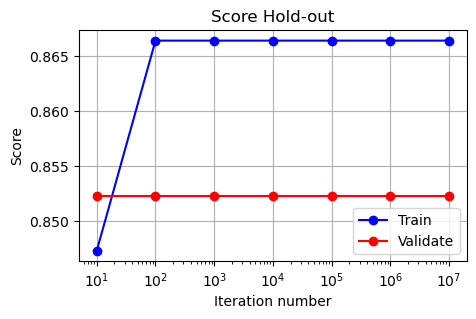

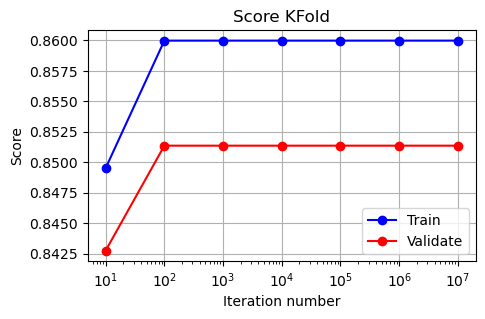

In [36]:
holdout_score_train_iter = []
holdout_score_validate_iter = []
kfold_score_train_iter = []
kfold_score_validate_iter = []

iter = [10, 100, 1000, 10000, 100000, 1000000, 10000000] # моссив с количеством итераций

pf_holdout_train = PolynomialFeatures(degree=np.argmax(holdout_score_train)+1)
pf_holdout_test = PolynomialFeatures(degree=np.argmax(holdout_score_validate)+1)
x_validate_poly = pf_holdout_test.fit_transform(x_validate)

for i in iter:
    
    logr_model_iter = LogisticRegression(penalty="l2", fit_intercept=True, max_iter=i, C=1e5,
                                solver="liblinear", random_state=12345)
    
    x_train_poly = pf_holdout_train.fit_transform(x_train)
    logr_model_iter.fit(x_train_poly, y_train)
    holdout_score_train_iter.append(logr_model_iter.score(x_train_poly, y_train))
    x_train_poly = pf_holdout_test.fit_transform(x_train) # преобразование к степени полинома 
    logr_model_iter.fit(x_train_poly, y_train) # переобучение на соответствующую степень полинома
    holdout_score_validate_iter.append(logr_model_iter.score(x_validate_poly, y_validate))
    
    pipeline_poly_KFold = Pipeline([("pf", PolynomialFeatures(degree=np.argmax(kfold_score_train)+1)),
                         ("logr", LogisticRegression(penalty="l2", fit_intercept=True, max_iter=i, C=1e5,
                                solver="liblinear", random_state=12345))])
    cv_results = cross_validate(pipeline_poly_KFold, x_train_main, y_train_main, cv=4, return_train_score=True)
    kfold_score_train_iter.append(np.mean(cv_results['train_score']))
    kfold_score_validate_iter.append(np.mean(cv_results['test_score']))
    

plt.figure(figsize=[5, 3])
plt.title("Score Hold-out")
plt.xlabel("Iteration number")
plt.ylabel("Score")
plt.plot(iter, holdout_score_train_iter, "b-o", label = 'Train')
plt.plot(iter, holdout_score_validate_iter, "r-o", label = 'Validate')
plt.legend()
plt.xscale('log')
plt.grid(True)

plt.figure(figsize=[5, 3])
plt.title("Score KFold")
plt.xlabel("Iteration number")
plt.ylabel("Score")
plt.plot(iter, kfold_score_train_iter, "b-o", label = 'Train')
plt.plot(iter, kfold_score_validate_iter, "r-o", label = 'Validate')
plt.legend()
plt.xscale('log')
plt.grid(True)

Из графиков видно что оценка намного меньше при количестве итераций равном 10, после чего увеличивается и достигает своего максимума при 100 итерациях, сохраняя значение оценки при последующем увеличении количества итераций.

Выведем оценку для модели, обученной на train подмножестве, и проверенной на обучающем и проверочном множества соответственно.

In [37]:
pf_train = PolynomialFeatures(degree=np.argmax(holdout_score_train)+1)
pf_validate = PolynomialFeatures(degree=np.argmax(holdout_score_validate)+1)
x_train_poly = pf_train.fit_transform(x_train)
x_validate_poly = pf_validate.fit_transform(x_validate)
logr_model = LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1e5,
                                solver="liblinear", random_state=12345)
logr_model.fit(x_train_poly, y_train)
print("Оценка модели для обучающего множества - ", logr_model.score(x_train_poly, y_train))
x_train_poly = pf_validate.fit_transform(x_train)
logr_model.fit(x_train_poly, y_train)
print("Оценка модели для обучающего множества - ",logr_model.score(x_validate_poly, y_validate))

Оценка модели для обучающего множества -  0.8664122137404581
Оценка модели для обучающего множества -  0.8522727272727273


Обучим модель на всем множестве train(x_train_main) и оценим на тестовом подмножестве(x_test)

In [38]:
pf_test = PolynomialFeatures(degree=np.argmax(holdout_score_validate)+1)
x_train_main_poly = pf_test.fit_transform(x_train_main)
logr_model = LogisticRegression(penalty="l2", fit_intercept=True, max_iter=100, C=1e5,
                                solver="liblinear", random_state=12345)
logr_model.fit(x_train_main_poly, y_train_main)
x_test_poly = pf_test.fit_transform(x_test)
print("Оценка модели для обучающего множества - ", logr_model.score(x_test_poly, y_test))

Оценка модели для обучающего множества -  0.86
